<a href="https://colab.research.google.com/github/kalalukakwalombota15/CEPS_PROJECTS/blob/main/01_onestep_forecasting_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/kalalukakwalombota15/CEPS_PROJECTS.git


Cloning into 'CEPS_PROJECTS'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 2.31 MiB | 5.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
%cd CEPS_PROJECTS
!ls -lah


/content/CEPS_PROJECTS
total 15M
drwxr-xr-x 3 root root 4.0K Jan 15 10:53  .
drwxr-xr-x 1 root root 4.0K Jan 15 10:53  ..
-rw-r--r-- 1 root root 400K Jan 15 10:53 'CEPS_dataset_assessment (2).ipynb'
-rw-r--r-- 1 root root  11M Jan 15 10:53  ceps_preprocessed.csv
-rw-r--r-- 1 root root 3.4M Jan 15 10:53 'data (1) (1).csv'
drwxr-xr-x 8 root root 4.0K Jan 15 10:53  .git
-rw-r--r-- 1 root root  761 Jan 15 10:53  README.md


In [ ]:
%cd /content/CEPS_PROJECTS
!pwd
!ls


/content/CEPS_PROJECTS
/content/CEPS_PROJECTS
'CEPS_dataset_assessment (2).ipynb'  'data (1) (1).csv'
 ceps_preprocessed.csv		      README.md


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
df = pd.read_csv("ceps_preprocessed.csv")

dt_col = df.columns[0]
df[dt_col] = pd.to_datetime(df[dt_col])
df = df.set_index(dt_col).sort_index()

print("Data shape:", df.shape)
df.head()


Data shape: (96672, 8)


,load_MW,load_with_pumping_MW,hour,dayofweek,hour_sin,hour_cos,dow_sin,dow_cos
timestamp,,,,,,,,
2015-01-01 00:00:00,6815.350,6815.350,0,3,0.000000,1.000000,0.433884,-0.900969
2015-01-01 01:00:00,6721.000,6721.000,1,3,0.258819,0.965926,0.433884,-0.900969
2015-01-01 02:00:00,6601.800,6606.917,2,3,0.500000,0.866025,0.433884,-0.900969
2015-01-01 03:00:00,6506.400,6634.833,3,3,0.707107,0.707107,0.433884,-0.900969
2015-01-01 04:00:00,6441.067,6957.633,4,3,0.866025,0.500000,0.433884,-0.900969


In [ ]:
TARGET = "load_MW"
FEATURES = ["load_MW", "hour_sin", "hour_cos", "dow_sin", "dow_cos"]

data = df[FEATURES].dropna().copy()
print("Modeling data shape:", data.shape)
data.head()


Modeling data shape: (96672, 5)


,load_MW,hour_sin,hour_cos,dow_sin,dow_cos
timestamp,,,,,
2015-01-01 00:00:00,6815.350,0.000000,1.000000,0.433884,-0.900969
2015-01-01 01:00:00,6721.000,0.258819,0.965926,0.433884,-0.900969
2015-01-01 02:00:00,6601.800,0.500000,0.866025,0.433884,-0.900969
2015-01-01 03:00:00,6506.400,0.707107,0.707107,0.433884,-0.900969
2015-01-01 04:00:00,6441.067,0.866025,0.500000,0.433884,-0.900969


In [ ]:
n = len(data)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

print("Train:", train_df.index.min(), "→", train_df.index.max(), train_df.shape)
print("Val  :", val_df.index.min(),   "→", val_df.index.max(),   val_df.shape)
print("Test :", test_df.index.min(),  "→", test_df.index.max(),  test_df.shape)


Train: 2015-01-01 00:00:00 → 2022-09-20 13:00:00 (67670, 5)
Val  : 2022-09-20 14:00:00 → 2024-05-16 18:00:00 (14501, 5)
Test : 2024-05-16 19:00:00 → 2026-01-10 23:00:00 (14501, 5)


In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

test_series = test_df[TARGET].values

# Persistence: y(t+1) = y(t)
y_true = test_series[1:]
y_pred = test_series[:-1]

print("=== Persistence baseline (1-step) ===")
print("MAE :", mean_absolute_error(y_true, y_pred))
print("RMSE:", rmse(y_true, y_pred))


=== Persistence baseline (1-step) ===
MAE : 239.23607931034482
RMSE: 320.6478830104684


In [ ]:
def seasonal_naive(series, season):
    series = np.asarray(series)
    y_true = series[season+1:]
    y_pred = series[1:-season]
    return y_true, y_pred

print("=== Seasonal naive baselines (1-step) ===")

yt, yp = seasonal_naive(test_series, 24)
print("Season=24h  | MAE:", mean_absolute_error(yt, yp), "| RMSE:", rmse(yt, yp))

yt, yp = seasonal_naive(test_series, 168)
print("Season=168h | MAE:", mean_absolute_error(yt, yp), "| RMSE:", rmse(yt, yp))


=== Seasonal naive baselines (1-step) ===
Season=24h  | MAE: 468.18930954683617 | RMSE: 704.4168678607114
Season=168h | MAE: 384.9806202204856 | RMSE: 605.077375554713


In [ ]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

target_idx = FEATURES.index(TARGET)

print("Scaled shapes:", train_scaled.shape, val_scaled.shape, test_scaled.shape)
print("Target index:", target_idx)


Scaled shapes: (67670, 5) (14501, 5) (14501, 5)
Target index: 0


In [ ]:
def make_windows(arr2d, lookback, horizon, target_idx):
    X, y = [], []
    T = len(arr2d)
    for end in range(lookback, T - horizon + 1):
        start = end - lookback
        X.append(arr2d[start:end, :])
        y.append(arr2d[end:end+horizon, target_idx])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    if horizon == 1:
        y = y.reshape(-1, 1)
    return X, y

LOOKBACK = 24
HORIZON  = 1

X_train, y_train = make_windows(train_scaled, LOOKBACK, HORIZON, target_idx)
X_val,   y_val   = make_windows(val_scaled,   LOOKBACK, HORIZON, target_idx)
X_test,  y_test  = make_windows(test_scaled,  LOOKBACK, HORIZON, target_idx)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (67646, 24, 5) y_train: (67646, 1)
X_val  : (14477, 24, 5) y_val  : (14477, 1)
X_test : (14477, 24, 5) y_test : (14477, 1)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

print("Torch version:", torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Torch version: 2.9.0+cpu
Device: cpu


In [ ]:
# Convert numpy arrays → torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test, dtype=torch.float32)

batch_size = 256

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)

print("Batches per epoch (train):", len(train_loader))


Batches per epoch (train): 265


In [ ]:
class MLPForecast(nn.Module):
    def __init__(self, lookback, n_features, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                           # (B, 24, 5) -> (B, 120)
            nn.Linear(lookback * n_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLPForecast(LOOKBACK, X_train.shape[-1], hidden=128).to(device)
model


MLPForecast(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
def evaluate(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            preds.append(out.cpu().numpy())
            trues.append(yb.cpu().numpy())
    preds = np.vstack(preds).reshape(-1)
    trues = np.vstack(trues).reshape(-1)
    return trues, preds

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val = np.inf
patience = 5
pat_count = 0
epochs = 30

for epoch in range(1, epochs+1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # validation
    yv_true, yv_pred = evaluate(model, val_loader)
    val_rmse = rmse(yv_true, yv_pred)

    print(f"Epoch {epoch:02d} | Train loss {np.mean(train_losses):.5f} | Val RMSE {val_rmse:.3f}")

    # early stopping
    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        pat_count = 0
        torch.save(model.state_dict(), "best_mlp.pt")
    else:
        pat_count += 1
        if pat_count >= patience:
            print("Early stopping.")
            break

# load best model
model.load_state_dict(torch.load("best_mlp.pt"))


Epoch 01 | Train loss 0.04253 | Val RMSE 0.125
Epoch 02 | Train loss 0.00853 | Val RMSE 0.102
Epoch 03 | Train loss 0.00674 | Val RMSE 0.093
Epoch 04 | Train loss 0.00591 | Val RMSE 0.090
Epoch 05 | Train loss 0.00528 | Val RMSE 0.082
Epoch 06 | Train loss 0.00504 | Val RMSE 0.080
Epoch 07 | Train loss 0.00513 | Val RMSE 0.078
Epoch 08 | Train loss 0.00470 | Val RMSE 0.078
Epoch 09 | Train loss 0.00464 | Val RMSE 0.084
Epoch 10 | Train loss 0.00447 | Val RMSE 0.080
Epoch 11 | Train loss 0.00454 | Val RMSE 0.094
Epoch 12 | Train loss 0.00439 | Val RMSE 0.092
Early stopping.


<All keys matched successfully>

In [ ]:
yt_true, yt_pred = evaluate(model, test_loader)

print("=== MLP Test Metrics (scaled target) ===")
print("MAE :", mean_absolute_error(yt_true, yt_pred))
print("RMSE:", rmse(yt_true, yt_pred))


=== MLP Test Metrics (scaled target) ===
MAE : 0.06732964515686035
RMSE: 0.08895570936323484


In [ ]:
# yt_true, yt_pred are in "scaled" units for the TARGET column only

target_mean = scaler.mean_[target_idx]
target_std  = scaler.scale_[target_idx]

yt_true_mw = yt_true * target_std + target_mean
yt_pred_mw = yt_pred * target_std + target_mean

print("=== MLP Test Metrics (MW units) ===")
print("MAE :", mean_absolute_error(yt_true_mw, yt_pred_mw))
print("RMSE:", rmse(yt_true_mw, yt_pred_mw))


=== MLP Test Metrics (MW units) ===
MAE : 92.39030969121669
RMSE: 122.065772165575


In [ ]:
# True MW values aligned to the NN test windows
# y_test contains the scaled target; we already inverted yt_true_mw above.

# Build persistence baseline aligned with the same timestamps used by windows:
test_target_mw = test_df[TARGET].values

# For each window prediction at time t, persistence predicts y(t) = y(t-1)
# Our windows start at index LOOKBACK, so first prediction corresponds to test_target_mw[LOOKBACK]
persist_pred_mw = test_target_mw[LOOKBACK-1:-1]   # y(t-1)
persist_true_mw = test_target_mw[LOOKBACK:]       # y(t)

print("=== Persistence baseline (aligned to NN test points) ===")
print("MAE :", mean_absolute_error(persist_true_mw, persist_pred_mw))
print("RMSE:", rmse(persist_true_mw, persist_pred_mw))
print("NN samples:", len(yt_true_mw), "Persistence samples:", len(persist_true_mw))


=== Persistence baseline (aligned to NN test points) ===
MAE : 239.23983794985145
RMSE: 320.64597076574796
NN samples: 14477 Persistence samples: 14477


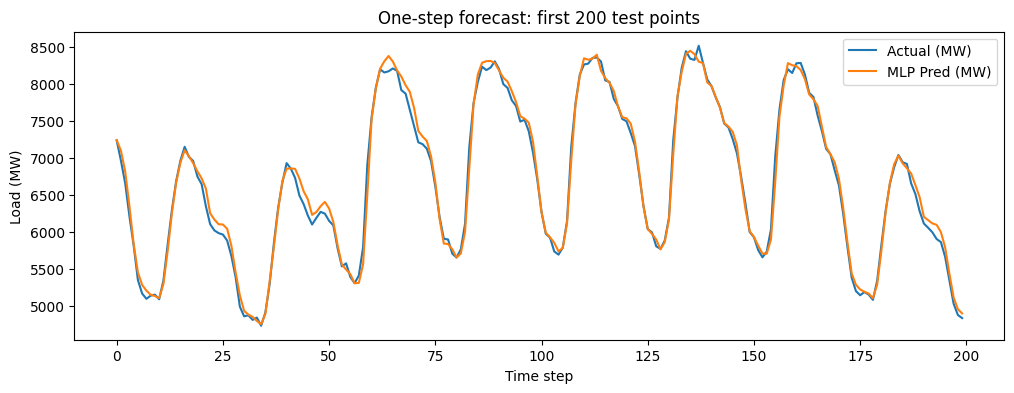

In [ ]:
N = 200  # first 200 hours of the NN test portion

plt.figure(figsize=(12,4))
plt.plot(yt_true_mw[:N], label="Actual (MW)")
plt.plot(yt_pred_mw[:N], label="MLP Pred (MW)")
plt.title("One-step forecast: first 200 test points")
plt.xlabel("Time step")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()


In [ ]:
class LSTMForecast(nn.Module):
    def __init__(self, n_features, hidden=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)      # out: (B, T, hidden)
        last = out[:, -1, :]       # last time step
        return self.fc(last)

lstm_model = LSTMForecast(n_features=X_train.shape[-1], hidden=64).to(device)
lstm_model


LSTMForecast(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer for LSTM
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

best_val = np.inf
patience = 5
pat_count = 0
epochs = 30

for epoch in range(1, epochs+1):
    lstm_model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = lstm_model(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # validation
    yv_true, yv_pred = evaluate(lstm_model, val_loader)
    val_rmse = rmse(yv_true, yv_pred)

    print(f"Epoch {epoch:02d} | Train loss {np.mean(train_losses):.5f} | Val RMSE {val_rmse:.4f}")

    # early stopping
    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        pat_count = 0
        torch.save(lstm_model.state_dict(), "best_lstm.pt")
    else:
        pat_count += 1
        if pat_count >= patience:
            print("Early stopping.")
            break

# Load best model
lstm_model.load_state_dict(torch.load("best_lstm.pt"))


Epoch 01 | Train loss 0.13455 | Val RMSE 0.1663
Epoch 02 | Train loss 0.01834 | Val RMSE 0.1468
Epoch 03 | Train loss 0.01289 | Val RMSE 0.1242
Epoch 04 | Train loss 0.01011 | Val RMSE 0.1163
Epoch 05 | Train loss 0.00865 | Val RMSE 0.1007
Epoch 06 | Train loss 0.00781 | Val RMSE 0.0949
Epoch 07 | Train loss 0.00697 | Val RMSE 0.0920
Epoch 08 | Train loss 0.00639 | Val RMSE 0.0863
Epoch 09 | Train loss 0.00583 | Val RMSE 0.0814
Epoch 10 | Train loss 0.00539 | Val RMSE 0.0802
Epoch 11 | Train loss 0.00516 | Val RMSE 0.0774
Epoch 12 | Train loss 0.00494 | Val RMSE 0.0751
Epoch 13 | Train loss 0.00484 | Val RMSE 0.0708
Epoch 14 | Train loss 0.00469 | Val RMSE 0.0747
Epoch 15 | Train loss 0.00454 | Val RMSE 0.0759
Epoch 16 | Train loss 0.00453 | Val RMSE 0.0722
Epoch 17 | Train loss 0.00433 | Val RMSE 0.0702
Epoch 18 | Train loss 0.00428 | Val RMSE 0.0691
Epoch 19 | Train loss 0.00420 | Val RMSE 0.0685
Epoch 20 | Train loss 0.00407 | Val RMSE 0.0709
Epoch 21 | Train loss 0.00399 | Val RMSE

<All keys matched successfully>

In [ ]:
yt_true_s, yt_pred_s = evaluate(lstm_model, test_loader)

print("=== LSTM Test Metrics (scaled) ===")
print("MAE :", mean_absolute_error(yt_true_s, yt_pred_s))
print("RMSE:", rmse(yt_true_s, yt_pred_s))


=== LSTM Test Metrics (scaled) ===
MAE : 0.05626952275633812
RMSE: 0.07556733461876053


In [ ]:
target_mean = scaler.mean_[target_idx]
target_std  = scaler.scale_[target_idx]

yt_true_mw = yt_true_s * target_std + target_mean
yt_pred_mw = yt_pred_s * target_std + target_mean

print("=== LSTM Test Metrics (MW) ===")
print("MAE :", mean_absolute_error(yt_true_mw, yt_pred_mw))
print("RMSE:", rmse(yt_true_mw, yt_pred_mw))


=== LSTM Test Metrics (MW) ===
MAE : 77.2135096424747
RMSE: 103.69412916325102


In [ ]:
test_target_mw = test_df[TARGET].values

persist_pred_mw = test_target_mw[LOOKBACK-1:-1]
persist_true_mw = test_target_mw[LOOKBACK:]

print("=== Persistence (aligned) ===")
print("MAE :", mean_absolute_error(persist_true_mw, persist_pred_mw))
print("RMSE:", rmse(persist_true_mw, persist_pred_mw))


=== Persistence (aligned) ===
MAE : 239.23983794985145
RMSE: 320.64597076574796


In [ ]:
LOOKBACK = 168   # 7 days of hourly history
HORIZON  = 1

X_train, y_train = make_windows(train_scaled, LOOKBACK, HORIZON, target_idx)
X_val,   y_val   = make_windows(val_scaled,   LOOKBACK, HORIZON, target_idx)
X_test,  y_test  = make_windows(test_scaled,  LOOKBACK, HORIZON, target_idx)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (67502, 168, 5) y_train: (67502, 1)
X_val  : (14333, 168, 5) y_val  : (14333, 1)
X_test : (14333, 168, 5) y_test : (14333, 1)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128

train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_ds   = TensorDataset(torch.tensor(X_val),   torch.tensor(y_val))
test_ds  = TensorDataset(torch.tensor(X_test),  torch.tensor(y_test))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print("DataLoaders ready.")


DataLoaders ready.


In [ ]:
lstm_model_168 = LSTMForecast(n_features=X_train.shape[-1], hidden=64).to(device)
lstm_model_168


LSTMForecast(
  (lstm): LSTM(5, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model_168.parameters(), lr=1e-3)

best_val = np.inf
patience = 5
pat_count = 0
epochs = 30

for epoch in range(1, epochs+1):
    lstm_model_168.train()
    train_losses = []

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        out = lstm_model_168(xb)
        loss = loss_fn(out, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # validation
    yv_true, yv_pred = evaluate(lstm_model_168, val_loader)
    val_rmse = rmse(yv_true, yv_pred)

    print(f"Epoch {epoch:02d} | Train loss {np.mean(train_losses):.5f} | Val RMSE {val_rmse:.4f}")

    # early stopping
    if val_rmse < best_val - 1e-4:
        best_val = val_rmse
        pat_count = 0
        torch.save(lstm_model_168.state_dict(), "best_lstm_168.pt")
    else:
        pat_count += 1
        if pat_count >= patience:
            print("Early stopping.")
            break

lstm_model_168.load_state_dict(torch.load("best_lstm_168.pt"))
print("Loaded best 168-lookback model.")


Epoch 01 | Train loss 0.07533 | Val RMSE 0.1411
Epoch 02 | Train loss 0.01279 | Val RMSE 0.1214
Epoch 03 | Train loss 0.00912 | Val RMSE 0.0986
Epoch 04 | Train loss 0.00744 | Val RMSE 0.0928
Epoch 05 | Train loss 0.00662 | Val RMSE 0.0823
Epoch 06 | Train loss 0.00609 | Val RMSE 0.0806
Epoch 07 | Train loss 0.00558 | Val RMSE 0.0835
Epoch 08 | Train loss 0.00531 | Val RMSE 0.0852
Epoch 09 | Train loss 0.00512 | Val RMSE 0.0821
Epoch 10 | Train loss 0.00477 | Val RMSE 0.0758
Epoch 11 | Train loss 0.00451 | Val RMSE 0.0706
Epoch 12 | Train loss 0.00435 | Val RMSE 0.0709
Epoch 13 | Train loss 0.00420 | Val RMSE 0.0693
Epoch 14 | Train loss 0.00409 | Val RMSE 0.0678
Epoch 15 | Train loss 0.00398 | Val RMSE 0.0679
Epoch 16 | Train loss 0.00388 | Val RMSE 0.0694
Epoch 17 | Train loss 0.00383 | Val RMSE 0.0659
Epoch 18 | Train loss 0.00370 | Val RMSE 0.0663
Epoch 19 | Train loss 0.00361 | Val RMSE 0.0683
Epoch 20 | Train loss 0.00352 | Val RMSE 0.0656
Epoch 21 | Train loss 0.00340 | Val RMSE

In [ ]:
# === Evaluate LSTM(168) on TEST and convert back to MW ===

yt_s, yp_s = evaluate(lstm_model_168, test_loader)   # scaled

# Ensure shape (N,1)
yt_s = np.array(yt_s).reshape(-1, 1)
yp_s = np.array(yp_s).reshape(-1, 1)

# Inverse-transform ONLY the target column using scaler stats
target_mean = scaler.mean_[target_idx]
target_scale = scaler.scale_[target_idx]

yt_mw = yt_s * target_scale + target_mean
yp_mw = yp_s * target_scale + target_mean

print("=== LSTM(168) TEST metrics (MW) ===")
print("MAE :", mean_absolute_error(yt_mw, yp_mw))
print("RMSE:", np.sqrt(mean_squared_error(yt_mw, yp_mw)))


=== LSTM(168) TEST metrics (MW) ===
MAE : 69.95900467491565
RMSE: 95.18476974517817


In [ ]:
LOOKBACK = 24


In [ ]:
X_train, y_train = make_windows(train_scaled, 24, 1, target_idx)
X_val, y_val     = make_windows(val_scaled,   24, 1, target_idx)
X_test, y_test   = make_windows(test_scaled,  24, 1, target_idx)


In [ ]:
lstm_model_24 = LSTMForecast(n_features=X_train.shape[-1]).to(device)


In [ ]:
yt_s, yp_s = evaluate(lstm_model_24, test_loader)


In [ ]:
import numpy as np
import torch

# pick which row to predict from the TEST set
# this index is the "end" position in test_scaled where we predict y at time t
i = LOOKBACK  # first possible prediction
# i = LOOKBACK + 1000  # try another

x = test_scaled[i-LOOKBACK:i, :]                  # shape (LOOKBACK, n_features)
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # (1, LOOKBACK, n_features)

lstm_model_168.eval()
with torch.no_grad():
    y_pred_scaled = lstm_model_168(x).cpu().numpy().reshape(-1, 1)  # (1,1)

# inverse-scale ONLY the target back to MW
y_pred_mw = y_pred_scaled * scaler.scale_[target_idx] + scaler.mean_[target_idx]
print("Predicted next-hour load (MW):", float(y_pred_mw[0,0]))

# True value in MW (aligned)
y_true_mw = test_df[TARGET].values[i]
print("True next-hour load (MW):     ", float(y_true_mw))
print("Absolute error (MW):          ", float(abs(y_true_mw - y_pred_mw[0,0])))


Predicted next-hour load (MW): 7151.7822669836105
True next-hour load (MW):      7240.067
Absolute error (MW):           88.28473301638951


In [ ]:
def predict_many_1step(model, scaled_array, start_i, n_preds, lookback, device):
    preds = []
    model.eval()
    with torch.no_grad():
        for i in range(start_i, start_i + n_preds):
            x = scaled_array[i-lookback:i, :]
            x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)
            yhat = model(x).cpu().numpy().reshape(-1, 1)  # (1,1)
            preds.append(yhat[0,0])
    return np.array(preds).reshape(-1, 1)

start_i = LOOKBACK
n_preds = 200

pred_scaled = predict_many_1step(lstm_model_168, test_scaled, start_i, n_preds, LOOKBACK, device)

pred_mw = pred_scaled * scaler.scale_[target_idx] + scaler.mean_[target_idx]
true_mw = test_df[TARGET].values[start_i:start_i+n_preds].reshape(-1, 1)

print("First 5 predictions vs true (MW):")
for k in range(5):
    print(k, "pred:", float(pred_mw[k,0]), "true:", float(true_mw[k,0]))


First 5 predictions vs true (MW):
0 pred: 7151.7822669836105 true: 7240.067
1 pred: 6924.946555202832 true: 6966.15
2 pred: 6648.607777424725 true: 6661.1
3 pred: 6374.700125393346 true: 6213.35
4 pred: 5808.700942965774 true: 5816.6


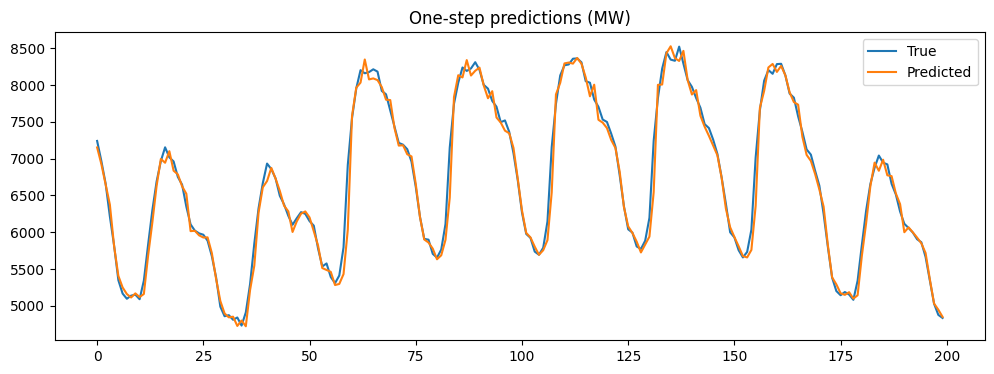

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(true_mw, label="True")
plt.plot(pred_mw, label="Predicted")
plt.legend()
plt.title("One-step predictions (MW)")
plt.show()


In [ ]:
# Residuals
residuals = true_mw - pred_mw

print("Residual statistics (MW)")
print("Mean error:", residuals.mean())
print("Std error :", residuals.std())
print("Max error :", residuals.max())
print("Min error :", residuals.min())


Residual statistics (MW)
Mean error: 38.856069185634375
Std error : 145.58595008181211
Max error : 881.4170621192434
Min error : -201.8551194209913


In [ ]:
corr = np.corrcoef(true_mw, pred_mw)[0, 1]
print("Correlation (True vs Predicted):", corr)


Correlation (True vs Predicted): nan


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


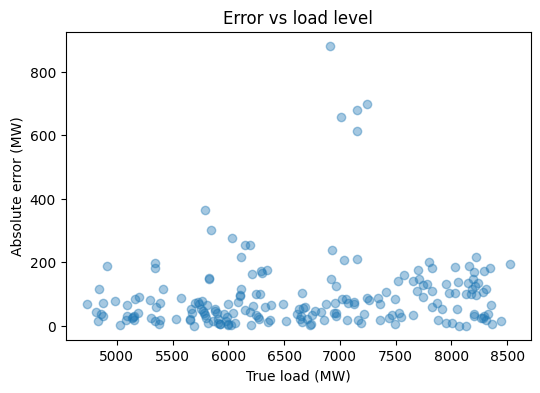

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(true_mw, np.abs(residuals), alpha=0.4)
plt.xlabel("True load (MW)")
plt.ylabel("Absolute error (MW)")
plt.title("Error vs load level")
plt.show()


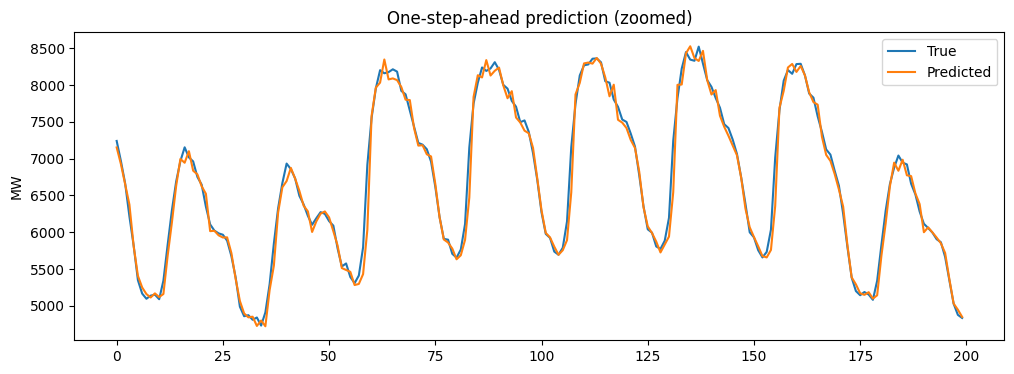

In [ ]:
n = 200  # first 200 points
plt.figure(figsize=(12,4))
plt.plot(true_mw[:n], label="True")
plt.plot(pred_mw[:n], label="Predicted")
plt.legend()
plt.title("One-step-ahead prediction (zoomed)")
plt.ylabel("MW")
plt.show()
